In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('Complete-dataset-FINAL.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4684 entries, 0 to 4683
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Method name          4684 non-null   object 
 1   N (no. labs)         4684 non-null   object 
 2   Mean                 4602 non-null   float64
 3   Bias                 4058 non-null   float64
 4   CV                   4584 non-null   float64
 5   Sample               4684 non-null   object 
 6   Reference Value      4656 non-null   float64
 7   Year                 4684 non-null   int64  
 8   Source (CAP/EurA1c)  4684 non-null   object 
 9   Type (Fresh/frozen)  4684 non-null   object 
 10  Manufacturer         4684 non-null   object 
 11  Total Error          4684 non-null   float64
dtypes: float64(5), int64(1), object(6)
memory usage: 439.2+ KB


In [3]:
df.head()

,Method name,N (no. labs),Mean,Bias,CV,Sample,Reference Value,Year,Source (CAP/EurA1c),Type (Fresh/frozen),Manufacturer,Total Error
0,Vitros 5.1 FS. 4600. 5600,183,6.14,-0.16,2.3,GH2-04,6.3,2011,CAP,Fresh,Vitros,4.348
1,Vitros 5.1 FS. 4600. 5600,183,7.59,-0.01,2.5,GH2-05,7.6,2011,CAP,Fresh,Vitros,4.890
2,Vitros 5.1 FS. 4600. 5600,183,9.42,0.22,3.0,GH2-06,9.2,2011,CAP,Fresh,Vitros,6.100
3,Vitros 5.1 FS. 4600. 5600,210,5.42,-0.18,2.3,GH2-01,5.6,2012,CAP,Fresh,Vitros,4.328
4,Vitros 5.1 FS. 4600. 5600,210,9.34,-0.06,2.6,GH2-02,9.4,2012,CAP,Fresh,Vitros,5.036


In [15]:
# Groupby Method name
manufacturer = df.dropna().groupby('Manufacturer')
# order manufacturer by size
manufacturerSizes = manufacturer.size().sort_values(ascending=False)
# Only show top more then 100 size
manufacturerSizes = manufacturerSizes[manufacturerSizes > 100]
# Make a new dataframe with the top manufacturers from df
df_manufacturer = df[df['Manufacturer'].isin(manufacturerSizes.index)]
df_manufacturer = df_manufacturer[df_manufacturer['Source (CAP/EurA1c)'] == 'CAP']
df_manufacturer

,Method name,N (no. labs),Mean,Bias,CV,Sample,Reference Value,Year,Source (CAP/EurA1c),Type (Fresh/frozen),Manufacturer,Total Error
0,Vitros 5.1 FS. 4600. 5600,183,6.14,-0.16,2.3,GH2-04,6.30,2011,CAP,Fresh,Vitros,4.348
1,Vitros 5.1 FS. 4600. 5600,183,7.59,-0.01,2.5,GH2-05,7.60,2011,CAP,Fresh,Vitros,4.890
2,Vitros 5.1 FS. 4600. 5600,183,9.42,0.22,3.0,GH2-06,9.20,2011,CAP,Fresh,Vitros,6.100
3,Vitros 5.1 FS. 4600. 5600,210,5.42,-0.18,2.3,GH2-01,5.60,2012,CAP,Fresh,Vitros,4.328
4,Vitros 5.1 FS. 4600. 5600,210,9.34,-0.06,2.6,GH2-02,9.40,2012,CAP,Fresh,Vitros,5.036
...,...,...,...,...,...,...,...,...,...,...,...,...
4679,Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems,204,9.08,0.22,3.1,GH5-01,8.86,2021,CAP,Fresh,Vitros,6.296
4680,Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems,204,6.86,0.02,2.6,GH5-02,6.84,2021,CAP,Fresh,Vitros,5.116
4681,Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems,204,9.40,0.01,3.4,GH5-03,9.39,2021,CAP,Fresh,Vitros,6.674
4682,Vitros 5.1 FS/4600/5600/XT7600 Chem. Systems,204,6.14,0.01,2.5,GH5-04,6.13,2021,CAP,Fresh,Vitros,4.910


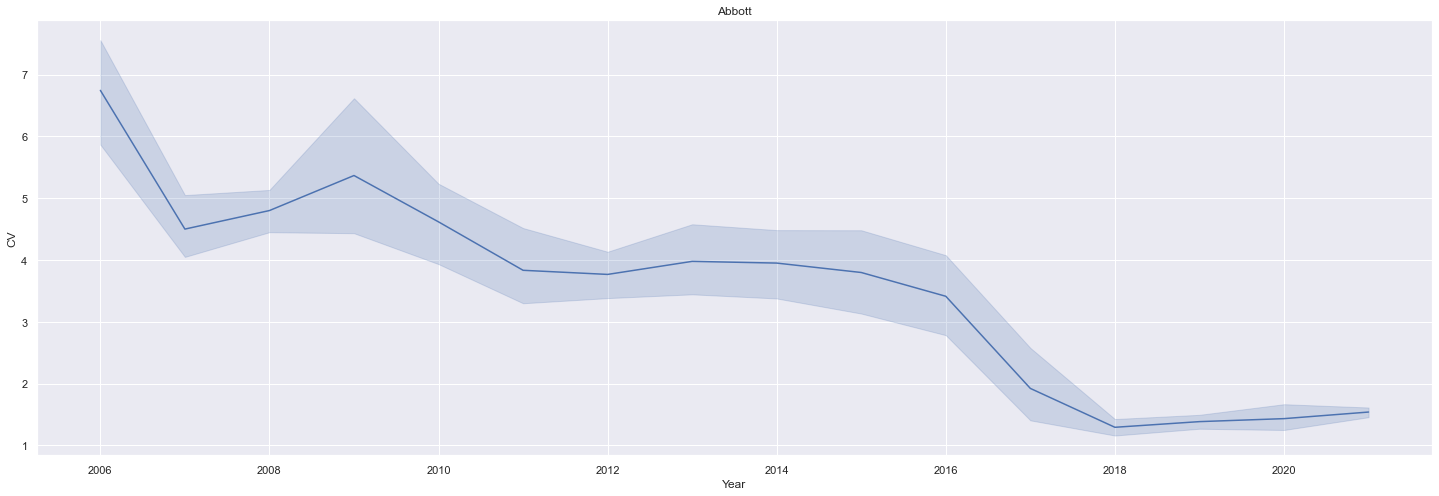

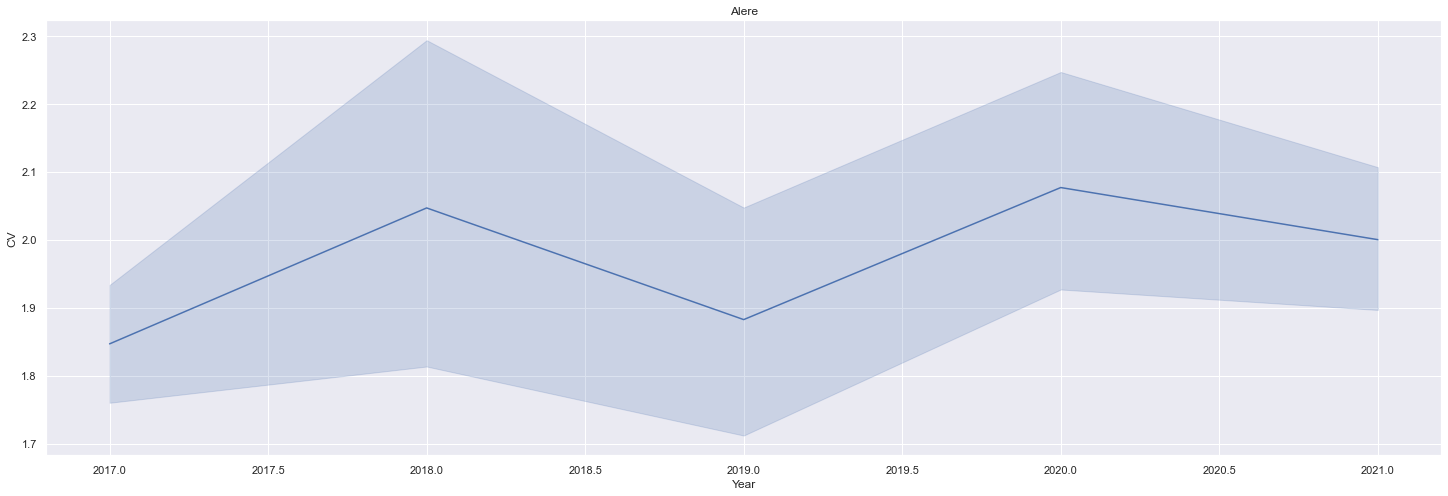

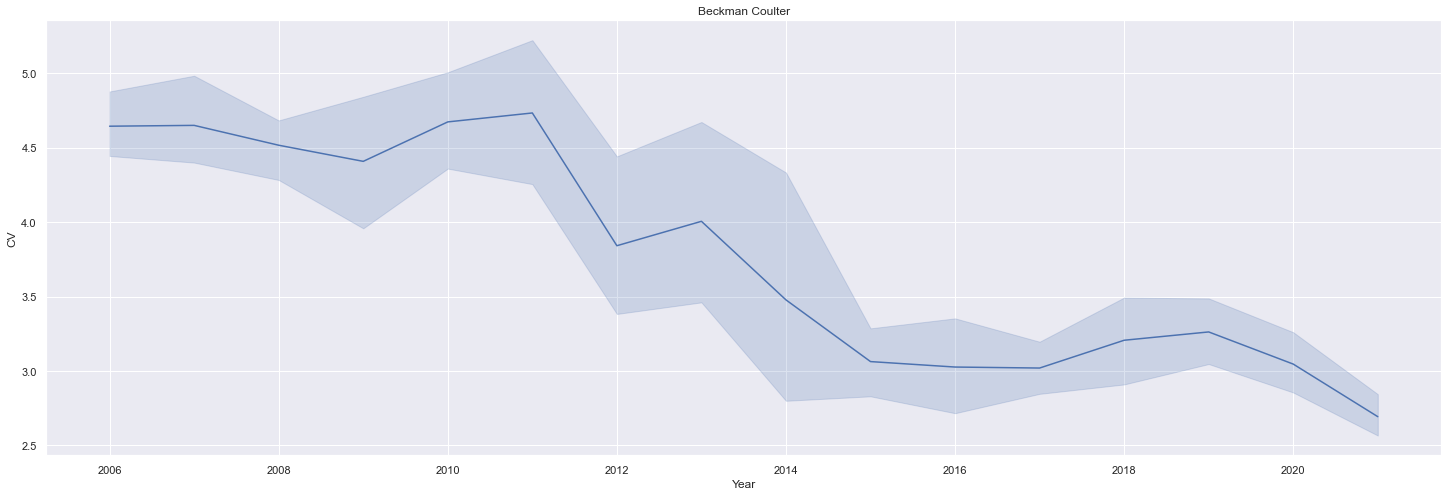

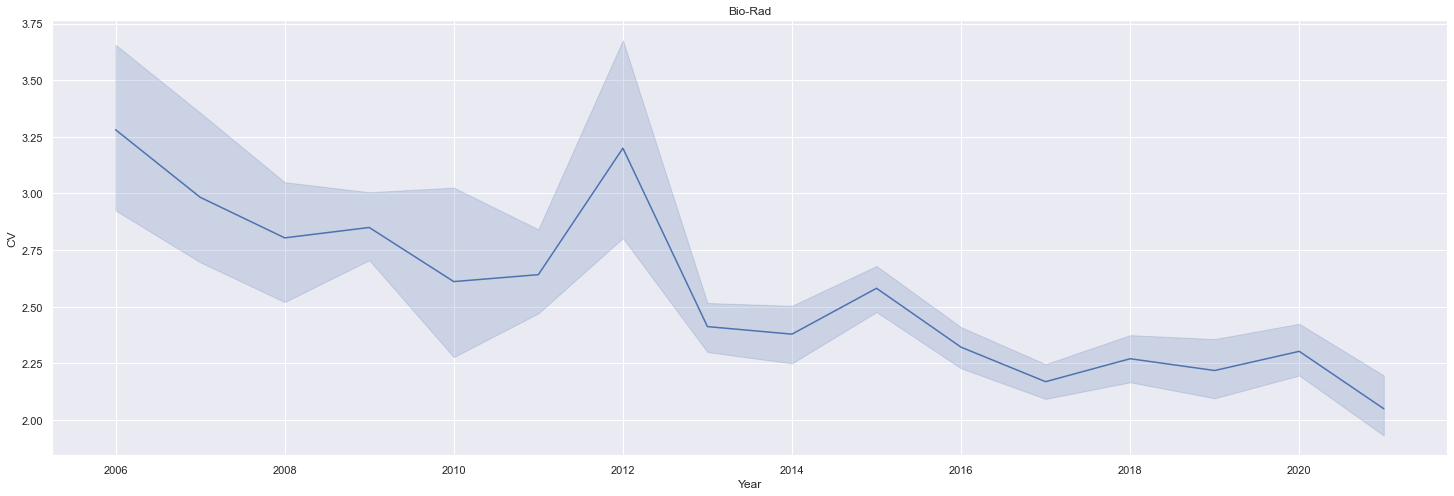

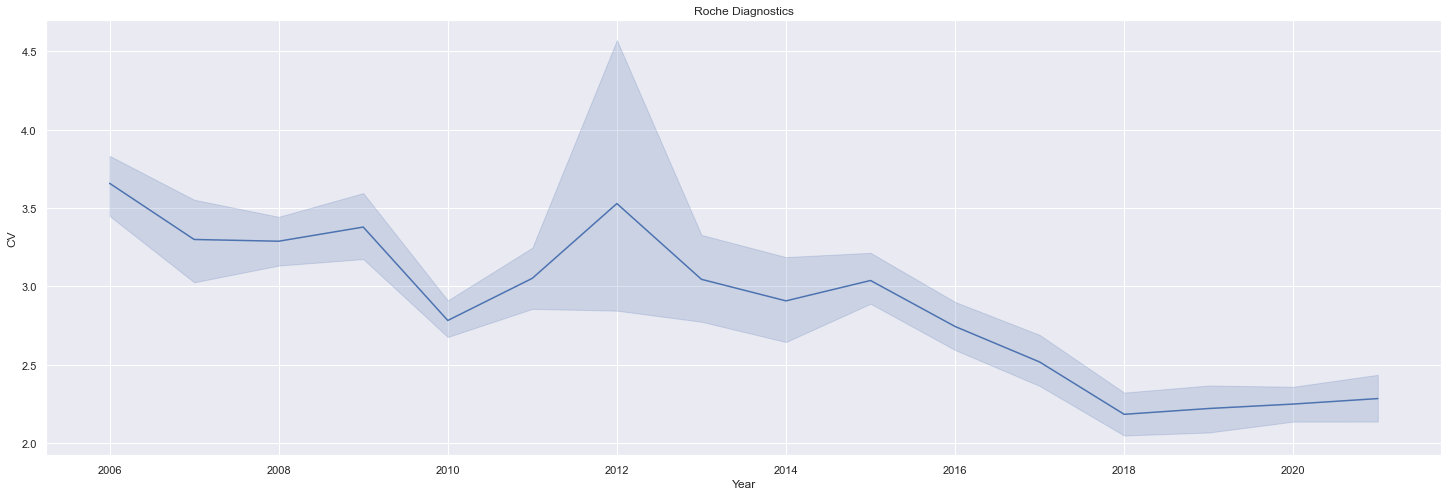

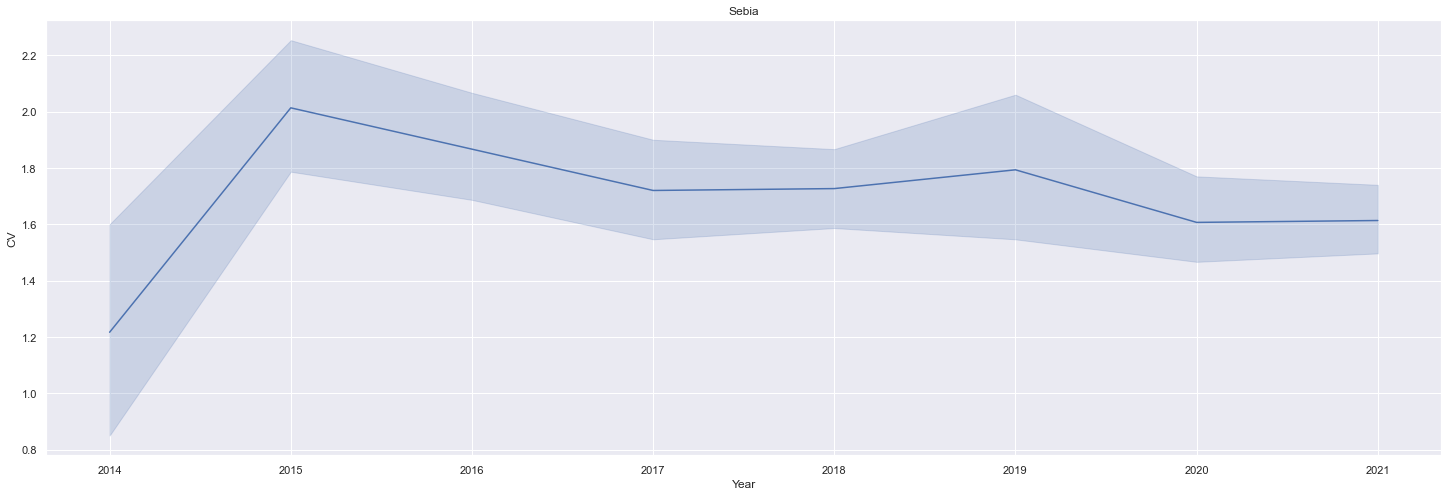

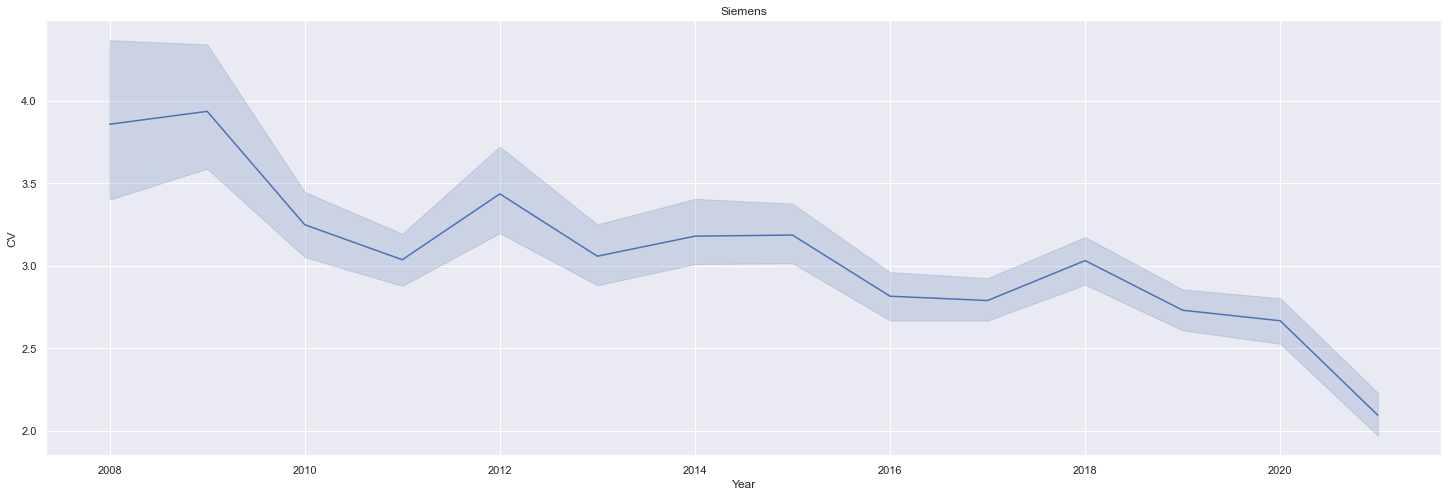

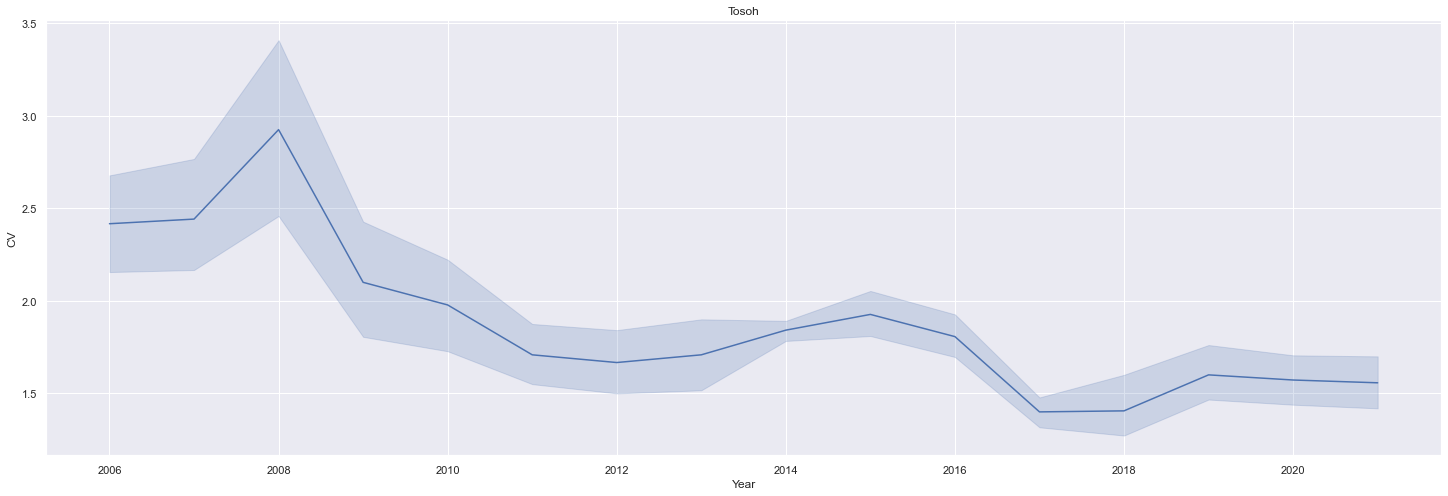

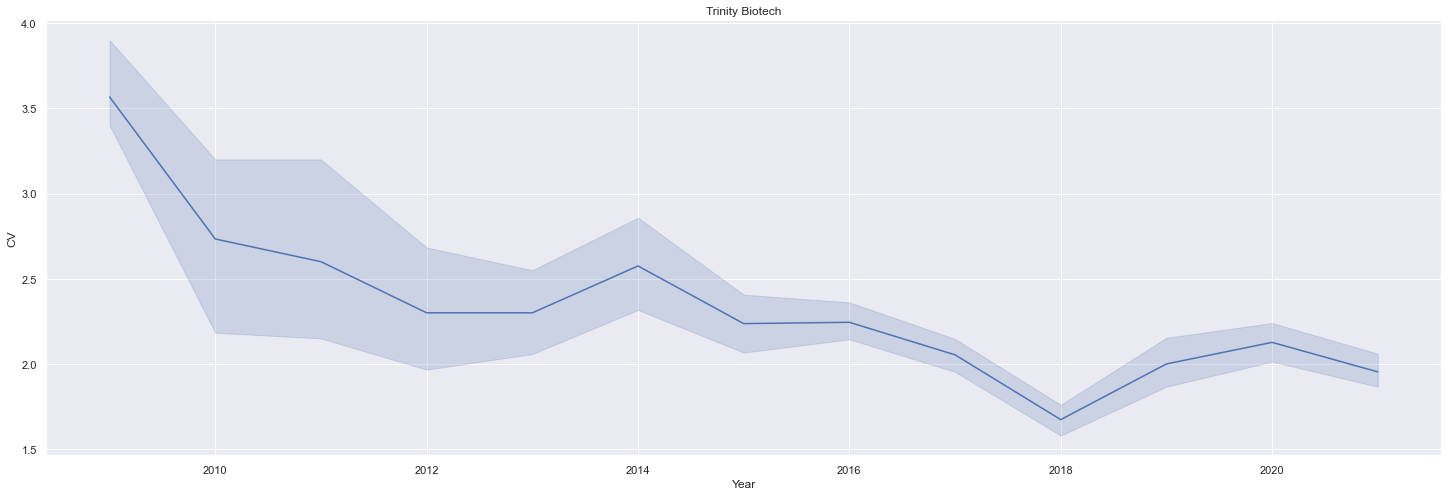

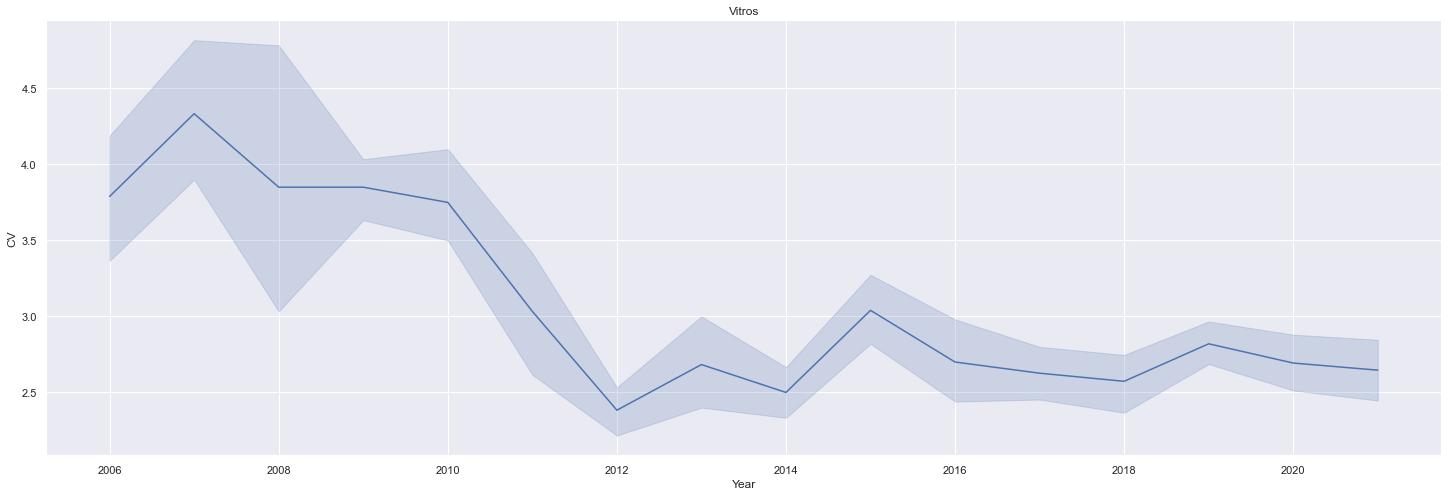

In [16]:
manufacturerGroups = df_manufacturer.groupby('Manufacturer')
# loop manufacturerGroups
for name, data in manufacturerGroups:
    # line plot for Total Error with seaborn
    # if name == "Abbott":
        sns.set(rc = {'figure.figsize':(25,8)})
        l = sns.lineplot(x='Year', y='CV', data=data)
        l.set_title(name)
        plt.show()
    

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.826
Model:                            OLS   Adj. R-squared (uncentered):              0.824
Method:                 Least Squares   F-statistic:                              366.6
Date:                Wed, 25 May 2022   Prob (F-statistic):                    5.22e-31
Time:                        14:27:01   Log-Likelihood:                         -136.74
No. Observations:                  78   AIC:                                      275.5
Df Residuals:                      77   BIC:                                      277.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

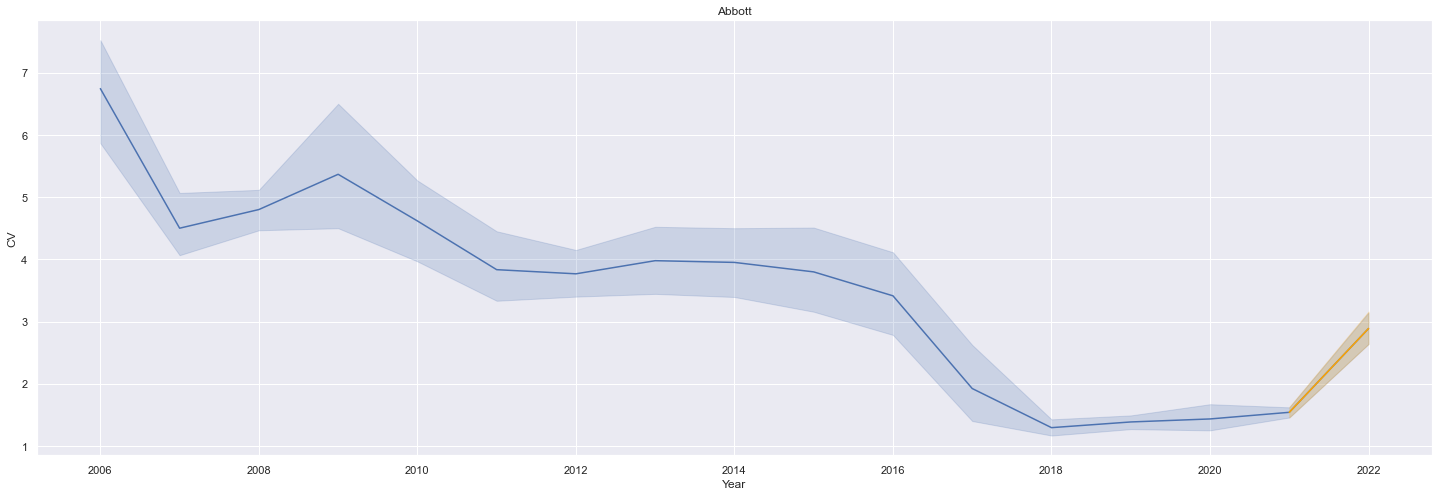

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              1047.
Date:                Wed, 25 May 2022   Prob (F-statistic):                    5.09e-26
Time:                        14:27:02   Log-Likelihood:                         -12.449
No. Observations:                  33   AIC:                                      26.90
Df Residuals:                      32   BIC:                                      28.39
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

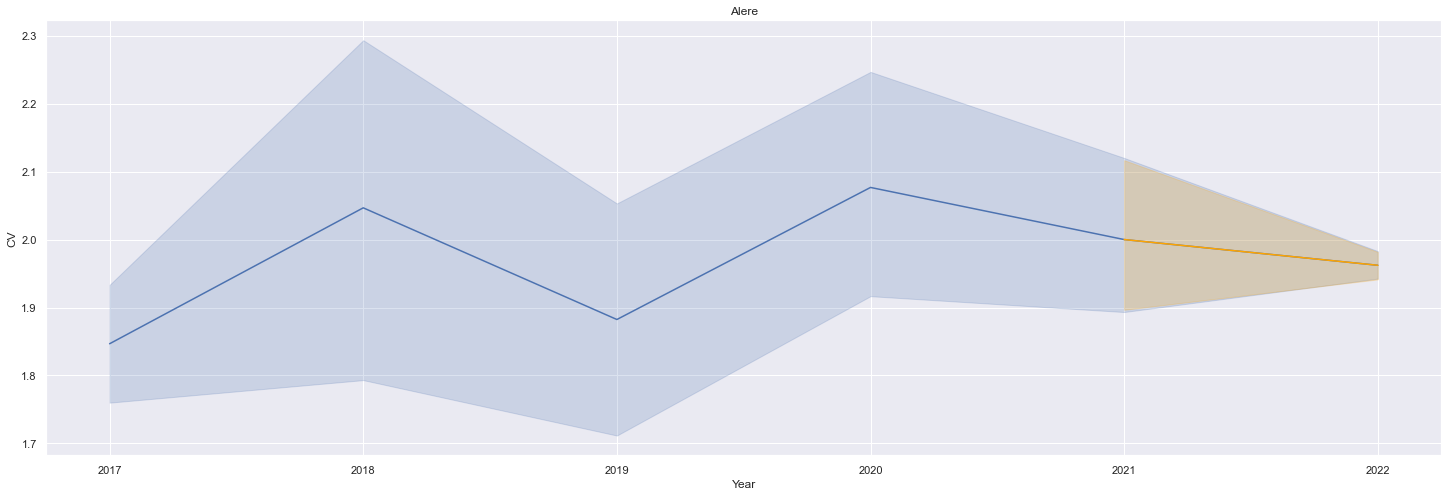

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              1960.
Date:                Wed, 25 May 2022   Prob (F-statistic):                    7.40e-69
Time:                        14:27:02   Log-Likelihood:                         -126.51
No. Observations:                 104   AIC:                                      255.0
Df Residuals:                     103   BIC:                                      257.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

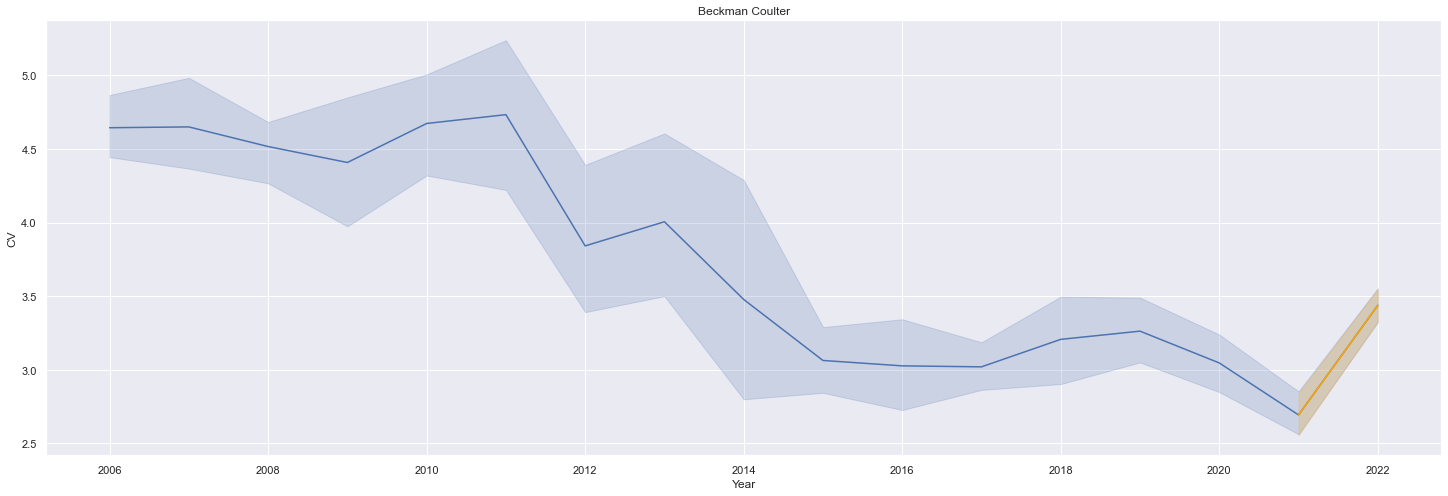

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.922
Method:                 Least Squares   F-statistic:                              2548.
Date:                Wed, 25 May 2022   Prob (F-statistic):                   7.99e-121
Time:                        14:27:03   Log-Likelihood:                         -239.33
No. Observations:                 215   AIC:                                      480.7
Df Residuals:                     214   BIC:                                      484.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

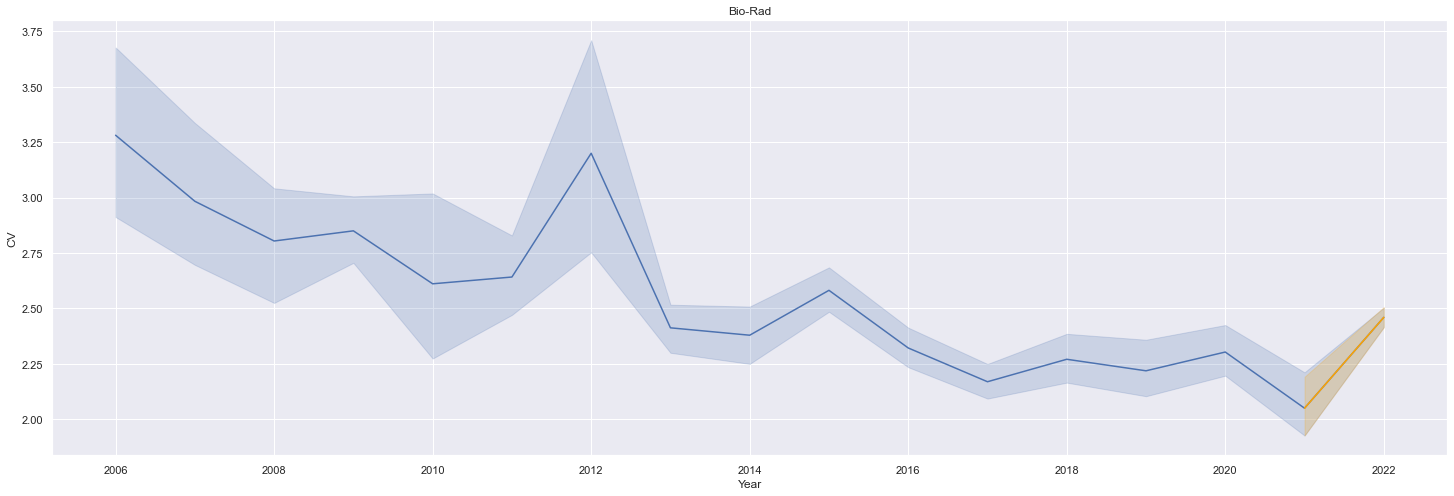

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.901
Model:                            OLS   Adj. R-squared (uncentered):              0.901
Method:                 Least Squares   F-statistic:                              1670.
Date:                Wed, 25 May 2022   Prob (F-statistic):                    6.22e-94
Time:                        14:27:03   Log-Likelihood:                         -243.32
No. Observations:                 184   AIC:                                      488.6
Df Residuals:                     183   BIC:                                      491.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

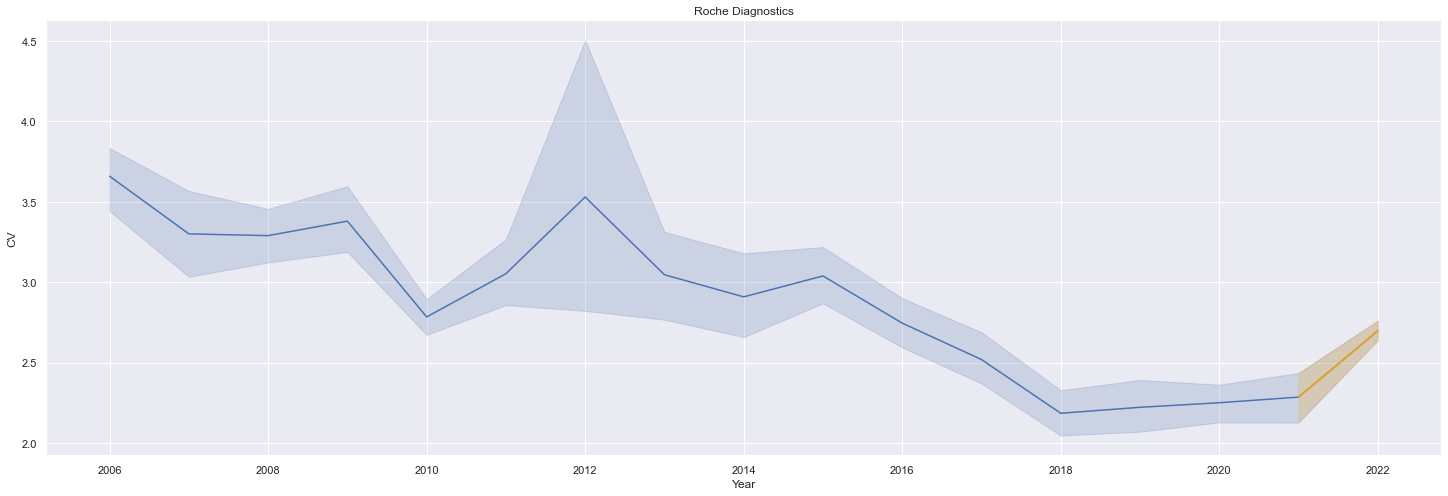

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              846.3
Date:                Wed, 25 May 2022   Prob (F-statistic):                    1.85e-29
Time:                        14:27:04   Log-Likelihood:                         -20.796
No. Observations:                  43   AIC:                                      43.59
Df Residuals:                      42   BIC:                                      45.35
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

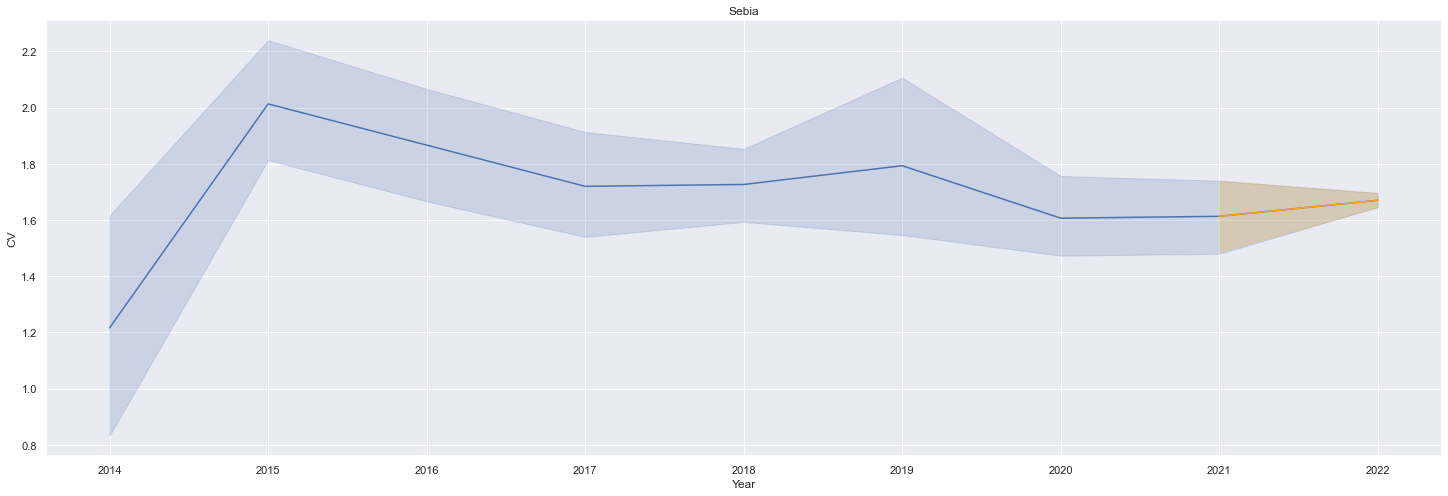

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              4875.
Date:                Wed, 25 May 2022   Prob (F-statistic):                   3.89e-176
Time:                        14:27:04   Log-Likelihood:                         -298.57
No. Observations:                 274   AIC:                                      599.1
Df Residuals:                     273   BIC:                                      602.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

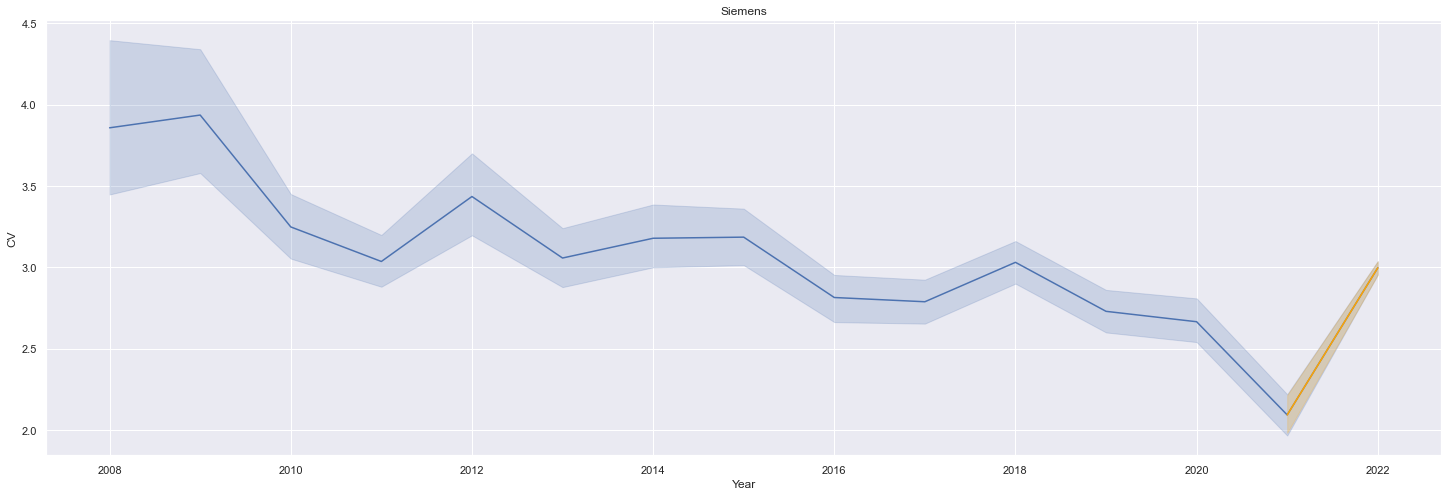

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              1392.
Date:                Wed, 25 May 2022   Prob (F-statistic):                    1.22e-53
Time:                        14:27:05   Log-Likelihood:                         -52.019
No. Observations:                  84   AIC:                                      106.0
Df Residuals:                      83   BIC:                                      108.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

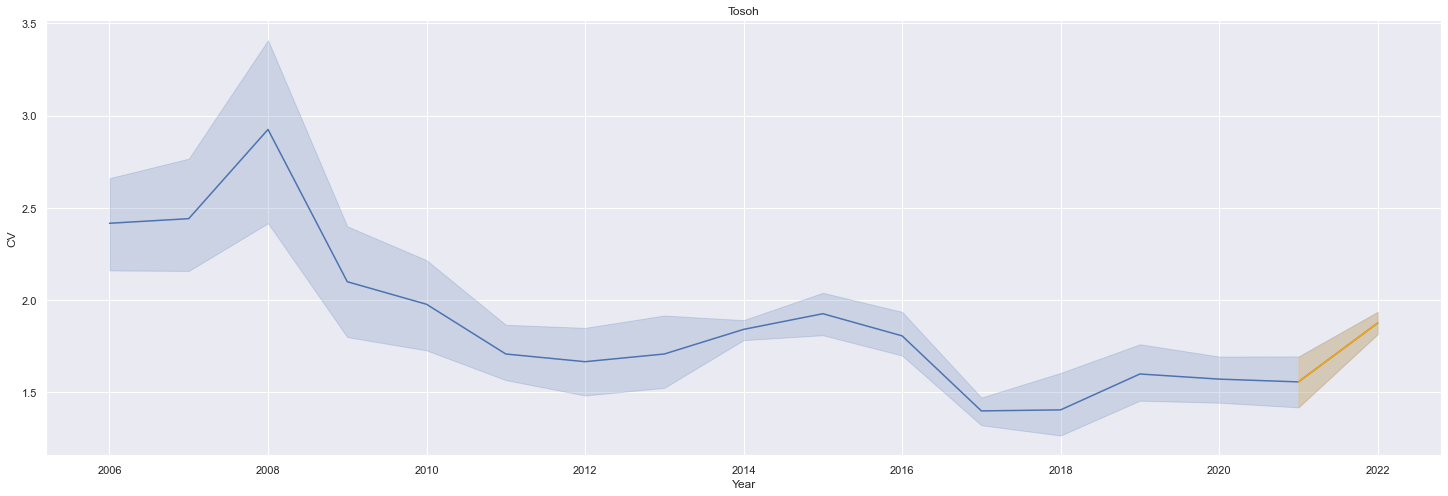

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              1466.
Date:                Wed, 25 May 2022   Prob (F-statistic):                    1.03e-38
Time:                        14:27:05   Log-Likelihood:                         -27.939
No. Observations:                  51   AIC:                                      57.88
Df Residuals:                      50   BIC:                                      59.81
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

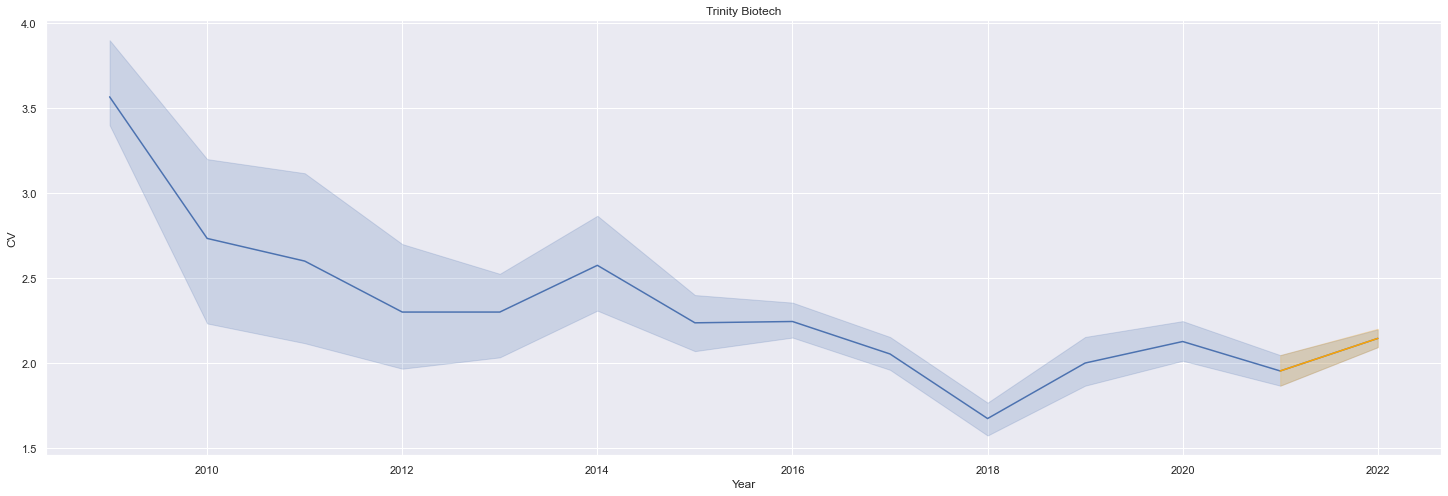

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              1396.
Date:                Wed, 25 May 2022   Prob (F-statistic):                    3.84e-37
Time:                        14:27:06   Log-Likelihood:                         -38.952
No. Observations:                  49   AIC:                                      79.90
Df Residuals:                      48   BIC:                                      81.80
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

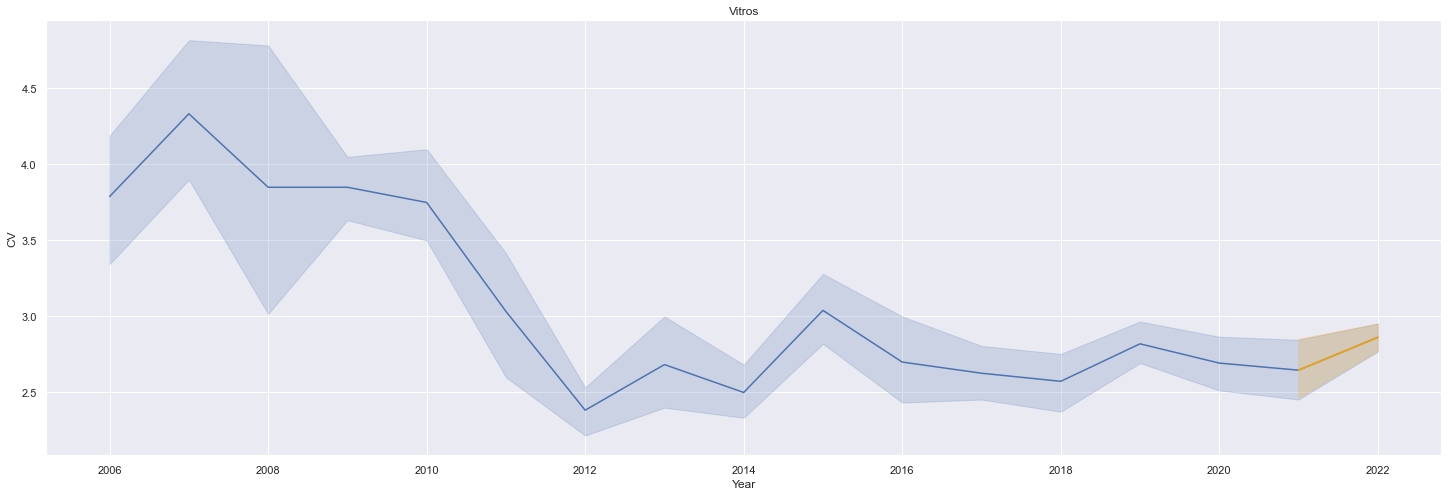

In [17]:
for name, data in manufacturerGroups:
    tempdf = data[['Year', 'CV']].dropna()

    X = tempdf.iloc[:, :-1].values
    Y = tempdf.iloc[:, 1].values

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

    from sklearn.linear_model import LinearRegression
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)

    preddf = pd.DataFrame(y_pred, columns=['CV'])
    preddf['Year'] = "2022"

    from statsmodels.api import OLS
    print(OLS(y_test,y_pred).fit().summary())

    # Add tempdf and preddf together and reset index
    tempdf = pd.concat([tempdf, preddf], axis=0, ignore_index=True)

    # Set the correct type 
    tempdf = tempdf.astype({'Year': 'int32'})

    sns.set(rc = {'figure.figsize':(25,8)})
    l = sns.lineplot(x='Year', y='CV', data=tempdf)
    l.set_title(name)
    sns.lineplot(x='Year', y='CV', data=tempdf[(tempdf['Year'] >= 2021) & (tempdf['Year'] <= 2022)], color='orange')
    plt.show()
    